In [ ]:
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
def genseq(lenseq):

    transition_prob = np.array([0.04, 0.05])

    die_prob = np.array([[1/6, 1/6, 1/6, 1/6, 1/6, 1/6],
                        [1/10, 1/10, 1/10, 1/10, 1/10, 1/2]])

    die = 0

    roll_seq = []
    label_seq = []

    for _ in np.arange(lenseq):

        roll = random.choice(np.arange(1,7), 1, p=die_prob[die])[0]
        roll_seq.append(roll)
        label_seq.append(die)

        if random.rand(1) < transition_prob[die]:
            die = (die + 1) % 2
    
        
    return np.array(roll_seq), np.array(label_seq)

In [ ]:
def plot_seq(roll_seq, color):

    colors = ['g', 'r', 'black']
    plt.figure(figsize=(40,5))
    timeTM = np.linspace(0, len(roll_seq)/2, len(roll_seq))
    for i, x in enumerate(timeTM): 
        plt.plot([x, x], [0, roll_seq[i]], c=colors[color[i]], )
    plt.xlim(0, 500)
    plt.ylim(1,6)
    plt.show()

In [ ]:
roll_seq, label_seq = genseq(1000)

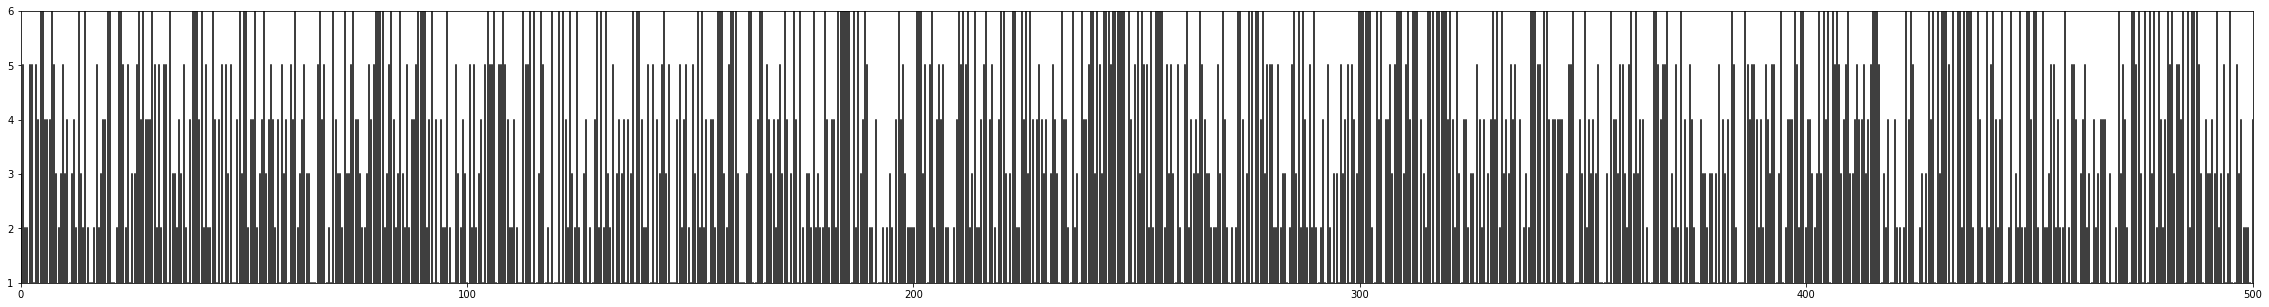

In [ ]:
plot_seq(roll_seq, np.full(len(roll_seq), 2))

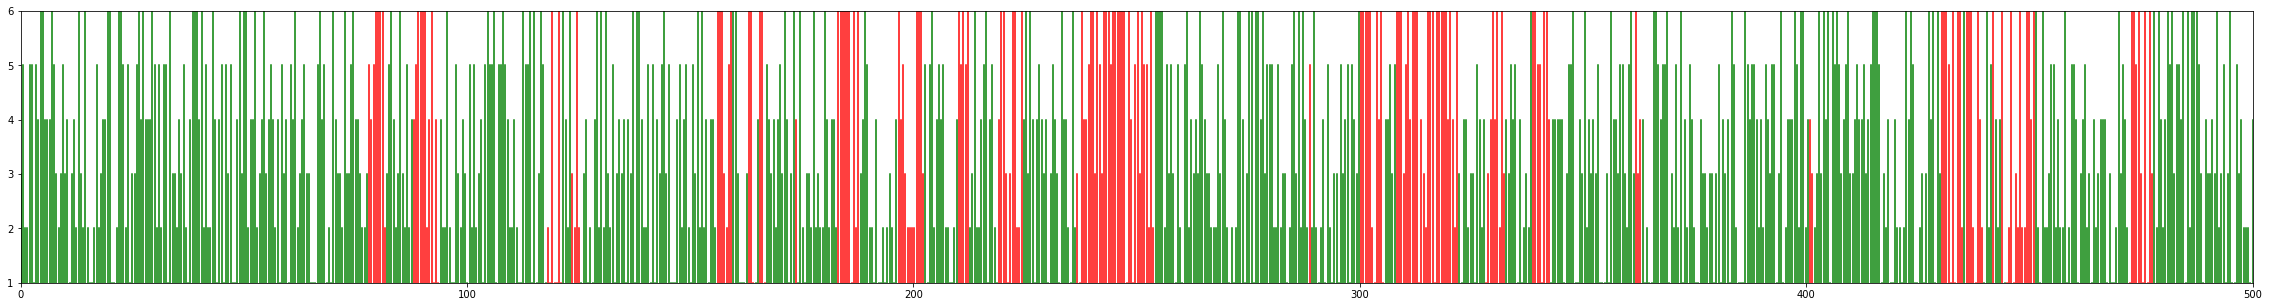

In [ ]:
plot_seq(roll_seq, label_seq)

# Heuristic approach

In [ ]:
def pred_heur(roll_seq, range, th):

    pred_points = np.zeros(len(roll_seq))
    for i in np.arange(len(roll_seq)):
        piece_of_seq = np.array(roll_seq[i:i+range])
        if np.sum(piece_of_seq==6)/range > th/range:

            pred_points[i:i+range] += np.sum(piece_of_seq==6)/range

    mean_points = np.mean(pred_points)
    return (pred_points > mean_points).astype(int)  

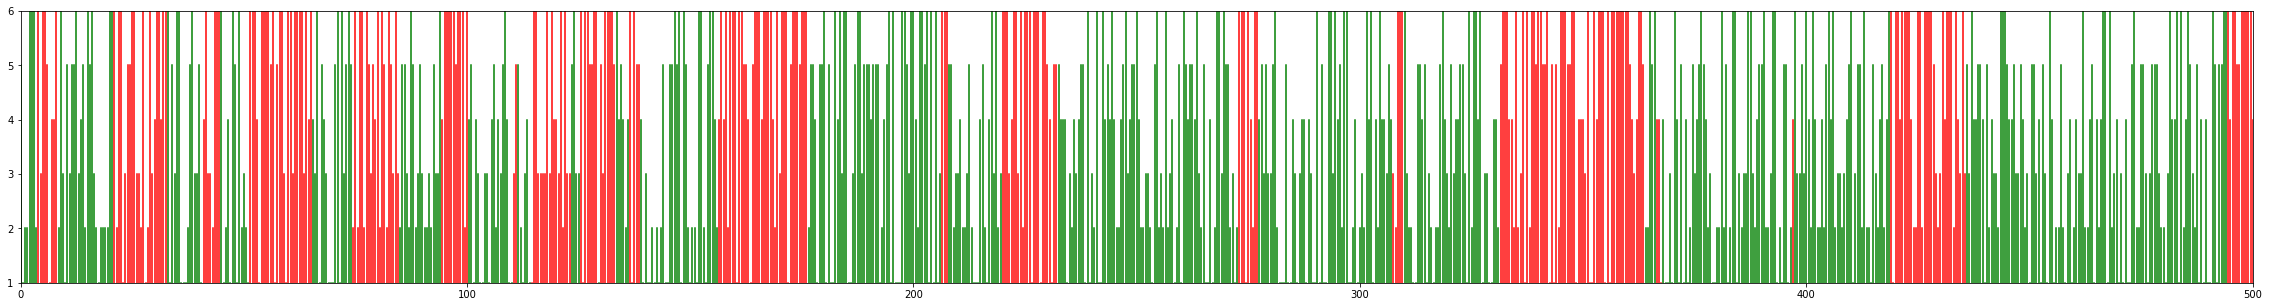

In [ ]:
roll_seq, label_seq = genseq(10000)
plot_seq(roll_seq, label_seq)

Accuracy: 0.8247


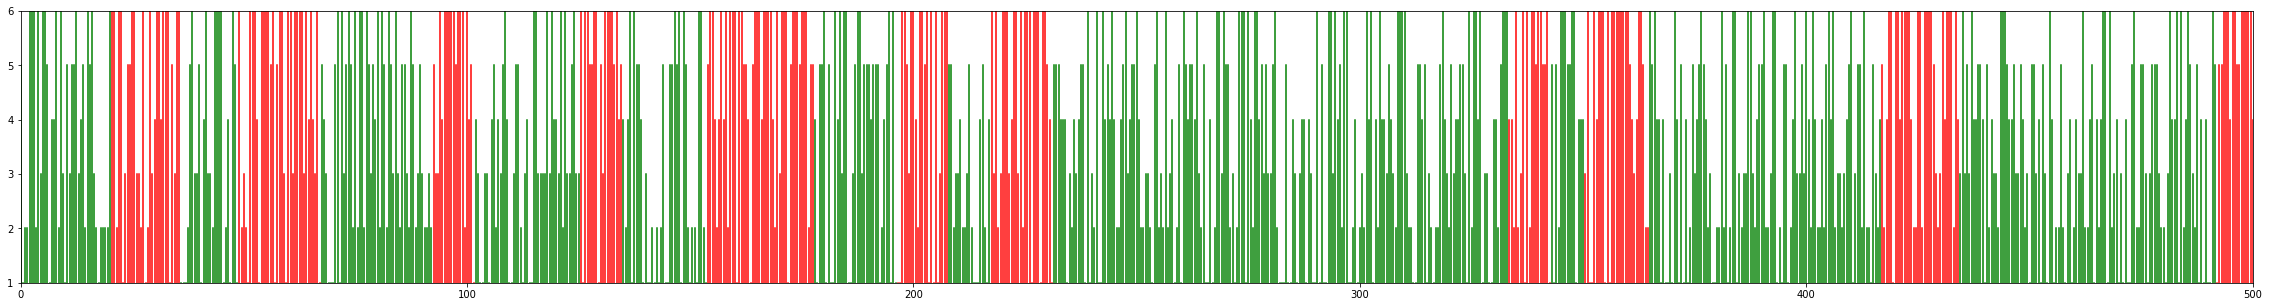

In [ ]:
target_seq = pred_heur(roll_seq, 15, 6)
print("Accuracy: {}".format(np.sum(target_seq == label_seq)/len(label_seq)))
plot_seq(roll_seq, target_seq)

**Accuracy varies between 60%-82%** 

# Alpha_Beta algorithm

In [ ]:
def alphabeta(roll_seq, initial_prob, trans_prob, obs_prob, return_seq=True):

    alpha_seq = np.zeros((2, len(roll_seq)), dtype=np.float128)
    alpha_seq[: , 0] = initial_prob
   
    for roll in np.arange(1, len(roll_seq)):
        for j in np.arange(len(init_prob)):
            alpha_seq[j, roll] = np.sum([alpha_seq[i, roll-1] * trans_prob[i, j] * obs_prob[j, roll_seq[roll-1]-1] * 6
                                         for i in np.arange(len(init_prob))])

    beta_seq = np.zeros((2, len(roll_seq)), dtype=np.float128)
    beta_seq[:, len(roll_seq)-1] =  [1, 1]

    for roll in np.arange(len(roll_seq) - 2, -1, -1):
        for j in np.arange(len(init_prob)):
            beta_seq[j, roll] = np.sum([beta_seq[i, roll+1] * trans_prob[i, j] * obs_prob[j, roll_seq[roll]-1] * 6 
                                        for i in np.arange(len(init_prob))])
    
    gamma_seq = (alpha_seq * beta_seq)/np.sum((alpha_seq*beta_seq))

    if return_seq:
        return np.argmax(gamma_seq, 0), np.argmax(alpha_seq, 0), np.argmax(beta_seq, 0)
    else:
        return gamma_seq, alpha_seq, beta_seq

In [ ]:
trans_prob = np.array([[1-0.04, 0.04], [0.05, 1-0.05]])

die_1_prob = np.array([1/6, 1/6, 1/6, 1/6, 1/6, 1/6])
die_2_prob = np.array([1/10, 1/10, 1/10, 1/10, 1/10, 1/2])

die_prob = np.array([die_1_prob, die_2_prob])
init_prob = np.array([1, 0])


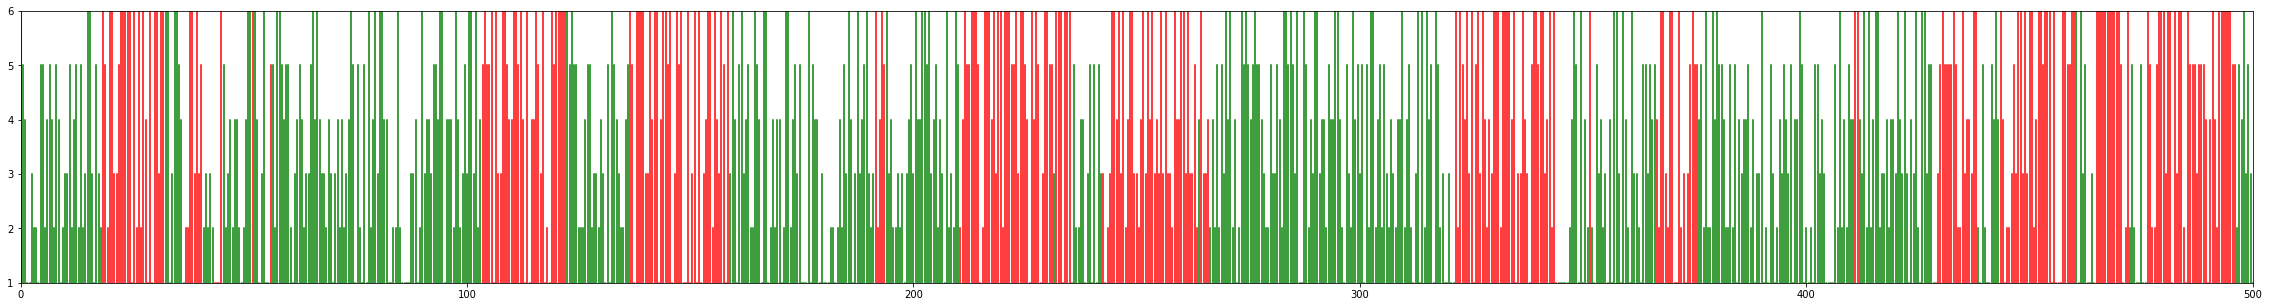

In [ ]:
roll_seq, label_seq = genseq(10000)
plot_seq(roll_seq, label_seq)

In [ ]:
target_seq = alphabeta(roll_seq, init_prob, trans_prob, die_prob)[0]
print("Accuracy: {}".format(np.sum(target_seq == label_seq)/len(label_seq)))
plot_seq(roll_seq, target_seq)

# Predicting Parameters

In [ ]:
def EM(seq, initial_prob, trans_prob, obs_prob, iters):

    def KSI(alpha_seq, beta_seq, trans_prob, obs_prob):
        ksi = np.zeros((len(seq) - 1, len(initial_prob), len(initial_prob)), dtype=np.float128)
        for roll in range(len(seq) - 1):
            for i in range(len(initial_prob)):
                for j in range(len(initial_prob)):
                    ksi[roll, j, i] = alpha_seq[i, roll] * trans_prob[i, j] * obs_prob[i, (seq[roll+1] - 1)] * beta_seq[j, roll+1]
        
        return ksi

    for _ in tqdm(range(iters)):
        gamma_seq, alpha_seq, beta_seq = alphabeta(roll_seq, initial_prob, trans_prob, obs_prob, return_seq=False)
        ksi = KSI(alpha_seq, beta_seq, trans_prob, obs_prob)

        ### trans_prob_HAT
        for i in range(len(initial_prob)):
            for j in range(len(initial_prob)):
                trans_prob[i, j] = np.sum(ksi[:, i, j])/np.sum(ksi[:, i, :])

        ### trans_obs_prob_hat
        for i in range(len(initial_prob)):
            for j in range(len(obs_prob[i])):
                obs_prob[i, j] = np.sum(gamma_seq[i, (seq - 1) == j]) / np.sum(gamma_seq[i, :])

        
    return trans_prob, obs_prob

In [ ]:

prob_die_1 = np.ones(6)
prob_die_2 = np.ones(6)

die_prob = np.array([prob_die_1/np.sum(prob_die_1) , prob_die_2/np.sum(prob_die_2)])

trans_prob = np.array([[1 - 0.5, 0.5],[0.5, 1 - 0.5]])

init_prob = np.array([0.5, 0.5])

EM(roll_seq, init_prob, trans_prob, die_prob, 1000)

100%|██████████| 1000/1000 [12:29<00:00,  1.33it/s]


(array([[0.5, 0.5],
        [0.5, 0.5]]), array([[0.1438, 0.1381, 0.1359, 0.1372, 0.1335, 0.3115],
        [0.1438, 0.1381, 0.1359, 0.1372, 0.1335, 0.3115]]))

In [ ]:
trans_1 = np.random.rand(1)[0]
trans_2 = np.random.rand(1)[0]

prob_die_1 = np.random.rand(6)
prob_die_2 = np.random.rand(6)

die_prob = np.array([prob_die_1/np.sum(prob_die_1) , prob_die_2/np.sum(prob_die_2)])

trans_prob = np.array([[1 - trans_1, trans_1],[trans_2, 1 - trans_2]])

init_prob = np.array([0.5, 0.5])

EM(roll_seq, init_prob, trans_prob, die_prob, 1000)

100%|██████████| 1000/1000 [12:32<00:00,  1.33it/s]


(array([[0.97829224, 0.02170776],
        [0.01732079, 0.98267921]]),
 array([[0.17256951, 0.15634354, 0.15778128, 0.16869016, 0.15963174,
         0.18498377],
        [0.10799251, 0.11538094, 0.10828265, 0.09754032, 0.10100698,
         0.4697966 ]]))

In [ ]:
casino = []

f = open('test.txt', 'r')
for line in f:
    for number in line:
        if number != '\n':
            casino.append(int(number))
casino = np.array(casino)

trans_1 = np.random.rand(1)[0]
trans_2 = np.random.rand(1)[0]

prob_die_1 = np.random.rand(6)
prob_die_2 = np.random.rand(6)

die_prob = np.array([prob_die_1/np.sum(prob_die_1) , prob_die_2/np.sum(prob_die_2)])

trans_prob = np.array([[1 - trans_1, trans_1],[trans_2, 1 - trans_2]])

init_prob = np.array([0.5, 0.5])

EM(casino, init_prob, trans_prob, die_prob, 1000)

100%|██████████| 1000/1000 [12:34<00:00,  1.33it/s]


(array([[0.61978874, 0.38021126],
        [0.27579663, 0.72420337]]),
 array([[0.13950566, 0.13781204, 0.18331116, 0.09439671, 0.16489068,
         0.28008376],
        [0.1394959 , 0.13779127, 0.1832919 , 0.09440239, 0.16490676,
         0.28011178]]))